<a id='Top'></a>

# Multisurv model training<a class='tocSkip'></a>

Train MultiSurv models with different combinations of input data modalities.

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext watermark

import sys
import os

import ipywidgets as widgets
import pandas as pd
import torch

if torch.cuda.is_available():
    print('>>> PyTorch detected CUDA <<<')

# Make modules in "src" dir visible
if os.getcwd() not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), 'src'))

import utils
from model import Model

>>> PyTorch detected CUDA <<<


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#DataLoader" data-toc-modified-id="DataLoader-1"><span class="toc-item-num">1&nbsp;&nbsp;</span><code>DataLoader</code></a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Different-intervals" data-toc-modified-id="Different-intervals-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Different intervals</a></span><ul class="toc-item"><li><span><a href="#Equidistant-times" data-toc-modified-id="Equidistant-times-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Equidistant times</a></span></li><li><span><a href="#By-duration-quantiles" data-toc-modified-id="By-duration-quantiles-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>By duration quantiles</a></span></li></ul></li><li><span><a href="#Pick-learning-rate" data-toc-modified-id="Pick-learning-rate-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Pick learning rate</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Fit</a></span><ul class="toc-item"><li><span><a href="#Save-model-weights" data-toc-modified-id="Save-model-weights-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Save model weights</a></span></li></ul></li><li><span><a href="#Check-validation-metrics" data-toc-modified-id="Check-validation-metrics-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Check validation metrics</a></span></li></ul></li></ul></div>

In [2]:
DATA = utils.INPUT_DATA_DIR
MODELS = utils.TRAINED_MODEL_DIR

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# `DataLoader`

In [3]:
data_modalities = widgets.SelectMultiple(
    options=['clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'wsi'],
    index=[0, 1],
    rows=6,
    description='Input data',
    disabled=False
)
display(data_modalities)

SelectMultiple(description='Input data', index=(0, 1), options=('clinical', 'mRNA', 'DNAm', 'miRNA', 'CNV', 'w…

In [5]:
os.listdir('/mnt/data/')

[]

In [4]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     batch_size=20,
                                     batch_size=128,
#                                     batch_size=32,
#                                     exclude_patients=exclude_cancers,
                                   )

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/Processed_Data/Clinical'

# Model

## Different intervals

If trying out different time interval outputs.

### Equidistant times

### By duration quantiles

In [5]:
labels = [(t, e) for t, e in dataloaders['train'].dataset.label_map.values()]
durations = [t for t, _ in labels]
events = [e for _, e in labels]

interval_cuts = utils.discretize_time_by_duration_quantiles(durations, events, 20)
interval_cuts = torch.from_numpy(interval_cuts)

In [6]:
#-----------------------------------------------------------------------------#
#                       PRE-TRAINED UNIMODAL MODELS                           #
#-----------------------------------------------------------------------------#

unimodal_weigths = {'clinical': 'clinical_lr0.0055_epoch100_concord0.76.pth',
                    'mRNA': None,
                    'DNAm': None,
                    'miRNA': None,
                    'CNV': None,
                    'wsi': None,}

unimodal_weigths = {k: os.path.join(MODELS, v) if v is not None else None
                    for k, v in unimodal_weigths.items()}

multisurv = Model(dataloaders=dataloaders,
                  unimodal_state_files=unimodal_weigths,
                  freeze_up_to='aggregator',
                  output_intervals=interval_cuts,
                  device=device)

Instantiating MultiSurv model...


/app/src/multisurv.py:84: UserWarning: Input data is unimodal: no fusion procedure.
  warnings.warn('Input data is unimodal: no fusion procedure.')
/app/src/model.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

(loading pretrained unimodal model weights...)


In [7]:
multisurv = Model(dataloaders=dataloaders,
#                   fusion_method='attention',
                  unimodal_state_files=unimodal_weigths,
                   output_intervals=multisurv.output_intervals.to(device),
                  device=device)

Instantiating MultiSurv model...
(loading pretrained unimodal model weights...)


In [8]:
print('Output intervals (in years):')
multisurv.output_intervals / 365

Output intervals (in years):


tensor([ 0.0000,  0.4301,  0.8521,  1.2027,  1.5781,  2.0712,  2.6630,  3.4000,
         4.1068,  4.9397,  6.0247,  7.3425,  8.5753, 10.5068, 12.8110, 14.5699,
        18.0630, 22.0575, 26.3945, 30.8274], device='cuda:0',
       dtype=torch.float64)

In [10]:
multisurv.model_blocks

['clinical_submodel', 'fc_block', 'risk_layer']

In [11]:
print('Trainable blocks:')
layer = None

for name, child in multisurv.model.named_children():
    for name_2, params in child.named_parameters():
        if name is not layer:
            print(f'   {name}: {params.requires_grad}')
        layer = name

Trainable blocks:
   clinical_submodel: True
   fc_block: True
   risk_layer: True


In [12]:
multisurv.model

MultiSurv(
  (clinical_submodel): ClinicalNet(
    (embedding_layers): ModuleList(
      (0): Embedding(32, 16)
      (1): Embedding(2, 1)
      (2): Embedding(9, 5)
      (3-5): 3 x Embedding(3, 2)
      (6): Embedding(16, 8)
      (7-8): 2 x Embedding(10, 5)
    )
    (embedding_dropout): Dropout(p=0.5, inplace=False)
    (bn_layer): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (linear): Linear(in_features=47, out_features=256, bias=True)
    (output_layer): FC(
      (fc): Sequential(
        (0): Dropout(p=0.5, inplace=False)
        (1): Linear(in_features=256, out_features=512, bias=True)
        (2): ReLU()
      )
    )
  )
  (fc_block): FC(
    (fc): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1): Linear(in_features=512, out_features=2048, bias=True)
      (2): ReLU()
      (3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): Dropout(p=0.5, inplace=False)
      (5): Linear(in_fea

## Pick learning rate

In [13]:
# GPU-compatible version of the completely fixed LR test

def gpu_fixed_lr_test_run(self, init_value=1e-8, final_value=10., beta=0.98):
    """GPU-compatible LR test that ensures all tensors are on the same device."""
    print(">>> Using GPU-COMPATIBLE FIXED lr_test.run method")
    
    power = (1 / (len(self.dataloader) - 1))
    mult = (final_value / init_value) ** power
    lr = init_value
    self.optimizer.param_groups[0]['lr'] = lr
    avg_loss = 0.
    best_loss = 0.
    batch_num = 0

    print('>>> Compute loss at increasing LR values')
    
    # Clear losses and lrs lists
    self.losses = []
    self.lrs = []

    for data in self.dataloader:
        batch_num += 1
        print('\r' + f'    Iterate over mini-batches: {str(batch_num)}', end='')

        try:
            # Unpack data
            if len(data) == 3:
                modality_data, time, event = data
            elif len(data) == 4:
                modality_data, time, event, pid = data
            
            # CRITICAL: Move ALL data to the same device as the model
            target_device = next(self.model.parameters()).device
            
            # Move modality data to device
            for key, value in modality_data.items():
                if isinstance(value, torch.Tensor):
                    modality_data[key] = value.to(target_device)
                elif isinstance(value, (list, tuple)):
                    modality_data[key] = tuple(v.to(target_device) if isinstance(v, torch.Tensor) else v for v in value)
            
            # Move time and event to device
            time = time.to(target_device)
            event = event.to(target_device)
            
            # Set model to train mode
            self.model.train()
            
            # Clear gradients
            self.optimizer.zero_grad()
            
            # Forward pass
            with torch.set_grad_enabled(True):
                feature_representations, risk = self.model(modality_data)
                modality_features = feature_representations['modalities']
                
                # Compute loss with proper device handling
                try:
                    # Ensure output_intervals are on the same device
                    if hasattr(self, 'output_intervals'):
                        breaks = self.output_intervals.to(target_device)
                    else:
                        breaks = torch.linspace(0, 10, 19, device=target_device)  # Fallback
                    
                    loss = self.criterion(risk, times=time, events=event, breaks=breaks, device=target_device)
                    
                except Exception as loss_error:
                    print(f"\nPrimary criterion failed: {loss_error}")
                    # Fallback to simple MSE loss on the same device
                    dummy_target = torch.ones_like(risk)  # This will be on the same device as risk
                    loss = torch.nn.functional.mse_loss(risk, dummy_target)
                    print("Using fallback MSE loss")
                
                # Add auxiliary loss if needed
                if self.aux_criterion is not None:
                    try:
                        if len(modality_features) >= 2:
                            target = torch.ones(modality_features[0].shape[0], device=target_device)
                            aux_loss = self.aux_criterion(modality_features[0], modality_features[1], target)
                            loss = loss + 0.1 * aux_loss
                    except Exception as aux_error:
                        print(f"\nAuxiliary criterion failed: {aux_error}")
            
            # Store the loss value
            loss_value = loss.item()
            
        except Exception as e:
            print(f"\nError at batch {batch_num}: {e}")
            break

        # Compute the smoothed loss
        avg_loss = (beta * avg_loss + (1 - beta) * loss_value)
        smoothed_loss = avg_loss / (1 - beta ** batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            print()
            print('    Exploding loss; finish test.')
            break

        # Record the best loss
        if smoothed_loss < best_loss or batch_num == 1:
            best_loss = smoothed_loss
            
        # Store the values
        self.losses.append(smoothed_loss)
        self.lrs.append(lr)

        # Do the backward pass and optimizer step
        try:
            loss.backward(retain_graph=False)
            self.optimizer.step()
        except Exception as e:
            print(f"\nBackward pass failed at batch {batch_num}: {e}")
            break

        # Update the lr for the next step
        lr *= mult
        self.optimizer.param_groups[0]['lr'] = lr
        
        # Stop after reasonable number of batches
        if batch_num >= 100:
            print("\nStopping after 100 batches")
            break

    print()
    print('    Completed test.')
    return self

# Apply the GPU-compatible fix
import lr_range_test
lr_range_test.LRRangeTest.run = gpu_fixed_lr_test_run
print("Applied GPU-compatible fix to LRRangeTest.run")

Applied GPU-compatible fix to LRRangeTest.run


In [14]:
%%time

multisurv.test_lr_range()
print()

>>> Using GPU-COMPATIBLE FIXED lr_test.run method
>>> Compute loss at increasing LR values
    Iterate over mini-batches: 68
    Completed test.

CPU times: user 33.7 s, sys: 548 ms, total: 34.3 s
Wall time: 2min 51s


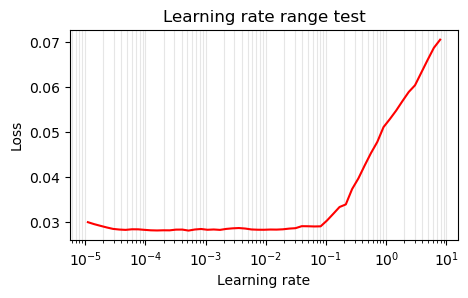

In [16]:
multisurv.plot_lr_range(trim=1)

## Fit

In [9]:
# GPU-compatible fix for _predictions_to_pycox method
def gpu_fixed_predictions_to_pycox(self, preds, time_points=None):
    """GPU-compatible version that properly handles device transfers."""
    import pandas as pd
    import torch
    
    # preds shape is [num_patients, num_intervals] e.g., [864, 18]
    # Convert predictions to DataFrame (move to CPU first)
    df = pd.DataFrame(preds.detach().cpu().numpy())  # Added .detach() for GPU tensors
    
    if time_points is None:
        # Get the number of intervals from the model output
        n_intervals = preds.shape[1]  # Should be 18 for your model
        
        # Use the model's actual output intervals
        if hasattr(self, 'output_intervals') and self.output_intervals is not None:
            # Handle GPU tensors properly
            intervals = self.output_intervals
            if torch.is_tensor(intervals):
                intervals = intervals.detach().cpu()  # Move to CPU for calculations
            
            if len(intervals) > n_intervals:
                # Take the first n_intervals midpoints
                midpoints = (intervals[:-1] + intervals[1:]) / 2
                time_points = midpoints[:n_intervals]
            else:
                # Fallback to evenly spaced points
                last_interval = intervals[-1].item() if torch.is_tensor(intervals) else intervals[-1]
                time_points = torch.linspace(0.5, last_interval / 365, n_intervals)
        else:
            # Fallback: create time points that match the output size
            time_points = torch.arange(0.5, 0.5 + n_intervals, 1.0)
    
    # Ensure time_points matches the prediction dimensions
    if len(time_points) != preds.shape[1]:
        print(f"Warning: Adjusting time_points from {len(time_points)} to {preds.shape[1]}")
        first_point = time_points[0].item() if torch.is_tensor(time_points) else time_points[0]
        last_point = time_points[-1].item() if torch.is_tensor(time_points) else time_points[-1]
        time_points = torch.linspace(first_point, last_point, preds.shape[1])
    
    # FIXED: The DataFrame structure should be transposed
    # We want columns to be time points, rows to be patients
    df = df.T  # Transpose so shape becomes [num_intervals, num_patients]
    
    # Convert time_points to numpy if it's a tensor (ensure CPU)
    if torch.is_tensor(time_points):
        time_points = time_points.detach().cpu().numpy()
    
    # Set the index to time points
    df.index = time_points
    df.index.name = 'time'
    
    return df

# Apply the GPU-compatible fix to ModelCoach
from coach import ModelCoach
ModelCoach._predictions_to_pycox = gpu_fixed_predictions_to_pycox
print("✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method")

# Debug info with GPU handling
print(f"Model output intervals shape: {len(multisurv.output_intervals)}")
print(f"Model output intervals device: {multisurv.output_intervals.device}")
print(f"Model risk layer output: {multisurv.model.risk_layer[0].out_features}")
print(f"Expected: {len(multisurv.output_intervals) - 1} intervals for {len(multisurv.output_intervals)} breakpoints")

✅ Applied GPU-compatible fix to ModelCoach._predictions_to_pycox method
Model output intervals shape: 20
Model output intervals device: cuda:0
Model risk layer output: 19
Expected: 19 intervals for 20 breakpoints


In [11]:
picked_lr = 1.5e-3

run_tag = utils.compose_run_tag(model=multisurv, lr=picked_lr,
                                dataloaders=dataloaders,
                                log_dir='.training_logs/',
                                suffix='')

Run tag: "clinical_lr0.0015"


In [12]:
fit_args = {
    'lr': picked_lr,
    'num_epochs': 100,
    'info_freq': 5,
#     'info_freq': None,
#     'lr_factor': 0.25,
#     'scheduler_patience': 5,
    'lr_factor': 0.25,
    'scheduler_patience': 5,
    'log_dir': os.path.join('.training_logs/', run_tag),
}

multisurv.fit(**fit_args)

Instantiating MultiSurv model...
(loading pretrained unimodal model weights...)

------------------------------------------
             Training        Validation
           ------------     ------------
 Epoch     Loss     Ctd     Loss     Ctd
------------------------------------------


/opt/conda/envs/multisurv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


 1/100    0.0286   0.746   0.0287   0.745
 5/100    0.0285   0.752   0.0288   0.744
 10/100   0.0284   0.751   0.0288   0.744
 15/100   0.0283   0.755   0.0287   0.748
 20/100   0.0283   0.755   0.0284   0.750
 25/100   0.0283   0.755   0.0284   0.750
 30/100   0.0283   0.756   0.0284   0.750
 35/100   0.0282   0.756   0.0284   0.751
 40/100   0.0282   0.758   0.0283   0.753
 45/100   0.0281   0.759   0.0284   0.753
 50/100   0.0282   0.759   0.0284   0.753
 55/100   0.0281   0.761   0.0283   0.753
 60/100   0.0281   0.760   0.0284   0.753
 65/100   0.0281   0.763   0.0283   0.753
 70/100   0.0280   0.764   0.0283   0.753
 75/100   0.0280   0.761   0.0283   0.753
 80/100   0.0281   0.763   0.0283   0.753
 85/100   0.0281   0.758   0.0284   0.754
 90/100   0.0281   0.759   0.0284   0.753
 95/100   0.0281   0.762   0.0284   0.753
 100/100  0.0282   0.761   0.0283   0.753

>>>>> Training completed in 4h 34m 28s
>>>>> Best validation C-indices:
     0.7534815389438225 (epoch65)
     0.7535

### Save model weights

If desired.

In [13]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
import glob

# 1) Path to your events file:
events_path = os.path.join('/app', '.training_logs/' ,run_tag)
event_files = glob.glob(os.path.join(events_path, "events.out.tfevents.*"))
if not event_files:
    raise FileNotFoundError(f"No TensorBoard event files found in {events_path}")
event_file = sorted(event_files, key=os.path.getmtime)[-1]  # use the newest
print(f"Using event file: {event_file}")

# 2) Load all scalar data
ea = EventAccumulator(event_file, size_guidance={"scalars": 0})
ea.Reload()

# 3) Check available scalar tags
print("Available scalar tags:", ea.Tags()["scalars"])
# => ['train_loss', 'train_concord', 'val_loss', 'val_concord']

# 4) Extract (epoch, value) pairs for val_concord
val_concord = [(e.step, e.value) for e in ea.Scalars("val_concord")]

# 5) Separate epochs and values
epochs = [step for step, _ in val_concord]
vals   = np.array([v for _, v in val_concord])

# 6) Compute 3-epoch moving average
window = 3
# 'valid' mode produces len(vals) - window + 1 points
smoothed = np.convolve(vals, np.ones(window)/window, mode="valid")
smoothed_epochs = epochs[window - 1 :]  # first smoothed point corresponds to epoch=window

# 7) Find epoch with highest smoothed val_concord
best_idx = np.argmax(smoothed)
best_epoch = smoothed_epochs[best_idx]
best_smoothed_concord = smoothed[best_idx]
print(f"Best smoothed val_concord = {best_smoothed_concord:.4f} at epoch {best_epoch}")

# 8) (Optional) print raw vs smoothed for inspection
print("\n epoch │ raw val_concord │ smoothed")
print("───────┼─────────────────┼──────────")
for ep, raw, sm in zip(smoothed_epochs, vals[window - 1 :], smoothed):
    print(f"  {ep:>2d}   │      {raw:.4f}     │  {sm:.4f}")


Using event file: /app/.training_logs/clinical_lr0.0015/events.out.tfevents.1751833771.b5e83bcbd78c.1656.0
Available scalar tags: ['train_loss', 'train_concord', 'val_loss', 'val_concord']
Best smoothed val_concord = 0.7534 at epoch 86

 epoch │ raw val_concord │ smoothed
───────┼─────────────────┼──────────
   3   │      0.7462     │  0.7459
   4   │      0.7455     │  0.7461
   5   │      0.7444     │  0.7453
   6   │      0.7426     │  0.7442
   7   │      0.7472     │  0.7447
   8   │      0.7483     │  0.7460
   9   │      0.7450     │  0.7468
  10   │      0.7437     │  0.7457
  11   │      0.7452     │  0.7447
  12   │      0.7473     │  0.7454
  13   │      0.7471     │  0.7465
  14   │      0.7481     │  0.7475
  15   │      0.7483     │  0.7479
  16   │      0.7480     │  0.7482
  17   │      0.7475     │  0.7480
  18   │      0.7493     │  0.7483
  19   │      0.7484     │  0.7484
  20   │      0.7499     │  0.7492
  21   │      0.7484     │  0.7489
  22   │      0.7487     

In [14]:
multisurv.best_model_weights.keys()

dict_keys(['epoch65', 'epoch85', 'epoch91'])

In [15]:
multisurv.best_concord_values

{'epoch65': 0.7534815389438225,
 'epoch85': 0.7535904615662542,
 'epoch91': 0.7534363759052533}

In [16]:
multisurv.current_concord

{'epoch100': 0.753064444999389}

In [19]:
multisurv.save_weights(saved_epoch='epoch85', prefix=run_tag, weight_dir=MODELS)

Saving model weights to file:
    /mnt/data/multisurv_models/clinical_lr0.0015_epoch85_concord0.75.pth


## Check validation metrics

In [28]:
dataloaders = utils.get_dataloaders(data_location=DATA,
                                    labels_file='/app/data/labels.tsv',
                                    modalities=data_modalities.value,
                                    wsi_patch_size=299,
                                    n_wsi_patches=5,
#                                     exclude_patients=exclude_cancers,
                                    return_patient_id=True,
                                   )

Data modalities:
   clinical

Dataset sizes (# patients):
   train: 8823
   val: 1102
   test: 1086

Batch size: 128


In [20]:
performance = utils.Evaluation(
    model=multisurv, dataset=dataloaders['val'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 1102/1102

C-index   0.76
Ctd       0.76
IBS       0.181
INBLL     0.541


In [21]:
performance = utils.Evaluation(
    model=multisurv, dataset=dataloaders['test'].dataset,
    device=device)
performance.compute_metrics()
performance.show_results()

Collect patient predictions: 1086/1086

C-index   0.748
Ctd       0.748
IBS       0.184
INBLL     0.542


# Watermark <a class='tocSkip'></a>

In [13]:
%watermark --iversions
%watermark -v
print()
%watermark -u -n

torch      1.4.0
ipywidgets 7.5.1
pandas     1.0.1

CPython 3.6.7
IPython 7.11.1

last updated: Tue Jul 28 2020


[Top of the page](#Top)